# Analyse Spectrale-Graphique: Conversion d'Image Hyperspectrale en Graphes Multi-échelles et Classification par GCN (utilisation des 20 bandes IOU)

**Ce notebook étend l'approche GCN en utilisant une sélection de bandes spectrales optimisée par segmentation égale. Au lieu d'utiliser toutes les bandes, il implémente une stratégie de segmentation qui divise le spectre en 20 segments égaux et sélectionne la bande optimale de chaque segment selon le critère de IOU. Cette approche "Equal 20 bands" garantit une couverture spectrale uniforme tout en maintenant la représentativité discriminante des bandes choisies. Le modèle GCN utilise ces 20 bandes sélectionnées comme caractéristiques nodales dans le graphe spatial, permettant d'évaluer l'impact de cette stratégie de sélection hybride (segmentation + optimisation) sur les performances de classification par rapport aux approches précédentes utilisant toutes les bandes ou une sélection purement basée sur les coefficients de déflexion.**

In [1]:
!pip install torch torch-geometric
!pip install networkx matplotlib scipy scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu1

In [2]:
# Import des bibliothèques nécessaires
import numpy as np
import torch
import scipy.io as sio
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import StandardScaler
import os

In [3]:
# Définir une seed fixe pour la reproductibilité
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Définir le chemin du dataset
dataset_path = "/kaggle/input/gcn2-dataset"  
output_path = "/kaggle/working/"  # Chemin pour sauvegarder les graphes générés

In [4]:
# Charger les données Indian Pines
def load_indian_pines():
    # Chargement de l'image hyperspectrale corrigée
    data = sio.loadmat(os.path.join(dataset_path, 'Indian_pines_corrected.mat'))
    # Vérifier les clés pour identifier le nom correct de la variable dans le fichier
    print("Clés disponibles dans le fichier corrected:", data.keys())
    # Généralement, c'est 'indian_pines_corrected' ou simplement 'X'
    # Nous allons supposer 'indian_pines_corrected', ajustez selon le contenu réel
    image = data['indian_pines_corrected']
    
    # Chargement des étiquettes (ground truth)
    gt_data = sio.loadmat(os.path.join(dataset_path, 'Indian_pines_gt.mat'))
    # Vérifier les clés également ici
    print("Clés disponibles dans le fichier gt:", gt_data.keys())
    # Généralement, c'est 'indian_pines_gt' ou simplement 'Y'
    gt = gt_data['indian_pines_gt']
    
    return image, gt

## Construction de Graphes Multi-échelles à partir d'Image Hyperspectrale: Implémentation de Connectivité Variable et Dilation Spatiale

In [5]:
# Fonction pour créer un graphe à partir de l'image hyperspectrale
def create_hyperspectral_graph(image, labels, selected_bands=None, dilation=1, connectivity_type='8-connectivity'):
    """
    Crée un graphe à partir d'une image hyperspectrale.
    
    Args:
        image: Image hyperspectrale de forme (height, width, bands)
        labels: Étiquettes de classe pour chaque pixel
        selected_bands: Indices des bandes spectrales à utiliser (si None, toutes les bandes sont utilisées)
        dilation: Rayon de voisinage pour la connectivité
        connectivity_type: Type de connectivité ('4-connectivity' ou '8-connectivity')
        
    Returns:
        data: Objet Data de PyTorch Geometric
    """
    # Vérification de la forme de l'image
    print("Forme originale de l'image:", image.shape)
    # Les données Indian Pines sont souvent organisées différemment (bands, height, width)
    # Nous devons nous assurer que la forme est (height, width, bands)
    if image.shape[0] > image.shape[1] and image.shape[0] > image.shape[2]:
        # Si c'est (bands, height, width)
        image = np.transpose(image, (1, 2, 0))
    elif image.shape[2] < image.shape[0] and image.shape[2] < image.shape[1]:
    # Si c'est (height, width, bands) - c'est déjà correct
        pass
    
    print("Forme ajustée de l'image:", image.shape)
    height, width, num_bands = image.shape
    num_pixels = height * width
    
    # Sélection des bandes
    if selected_bands is not None:
        features = image[:, :, selected_bands]
        print(f"Utilisation de {len(selected_bands)} bandes sélectionnées")
    else:
        features = image
        print(f"Utilisation de toutes les {num_bands} bandes")
    # Reshape pour avoir une liste de pixels
    X = features.reshape(num_pixels, -1)
    
    # Normalisation des caractéristiques
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Conversion en tensor PyTorch
    x = torch.FloatTensor(X)
    
    # Création des arêtes selon le type de connectivité
    edge_list = []
    # Définir le pattern de connectivité
    if connectivity_type == '4-connectivity':
        # Connectivité-4: haut, bas, gauche, droite
        directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    else:  # 8-connectivity
        # Connectivité-8: ajout des diagonales
        directions = [(0, 1), (0, -1), (1, 0), (-1, 0), 
                     (1, 1), (1, -1), (-1, 1), (-1, -1)]
    
    # Créer les arêtes en appliquant la dilation
    for i in range(height):
        for j in range(width):
            pixel_idx = i * width + j
     # Appliquer la dilation
            for di, dj in directions:
                for d in range(1, dilation + 1):
                    ni, nj = i + di * d, j + dj * d
                    # Vérifier que le voisin est dans les limites de l'image
                    if 0 <= ni < height and 0 <= nj < width:
                        neighbor_idx = ni * width + nj
                        edge_list.append((pixel_idx, neighbor_idx))
    
    # Conversion en tensor pour PyTorch Geometric
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    # Conversion des étiquettes
    y = torch.tensor(labels.reshape(-1), dtype=torch.long)
    
    # Création de l'objet Data
    data = Data(x=x, edge_index=edge_index, y=y)
    
    # Ajout d'informations supplémentaires pour faciliter l'analyse
    data.num_nodes = num_pixels
    data.height = height
    data.width = width
    
    return data

Chargement des données Indian Pines...
Clés disponibles dans le fichier corrected: dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_corrected'])
Clés disponibles dans le fichier gt: dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_gt'])
Forme de l'image: (145, 145, 200)
Forme des étiquettes: (145, 145)
Bandes sélectionnées par méthode Equal Spacing (une par segment):
  Segment 1: Bande 0
  Segment 2: Bande 19
  Segment 3: Bande 27
  Segment 4: Bande 38
  Segment 5: Bande 44
  Segment 6: Bande 52
  Segment 7: Bande 60
  Segment 8: Bande 74
  Segment 9: Bande 84
  Segment 10: Bande 93
  Segment 11: Bande 102
  Segment 12: Bande 116
  Segment 13: Bande 125
  Segment 14: Bande 130
  Segment 15: Bande 142
  Segment 16: Bande 159
  Segment 17: Bande 163
  Segment 18: Bande 172
  Segment 19: Bande 180
  Segment 20: Bande 199


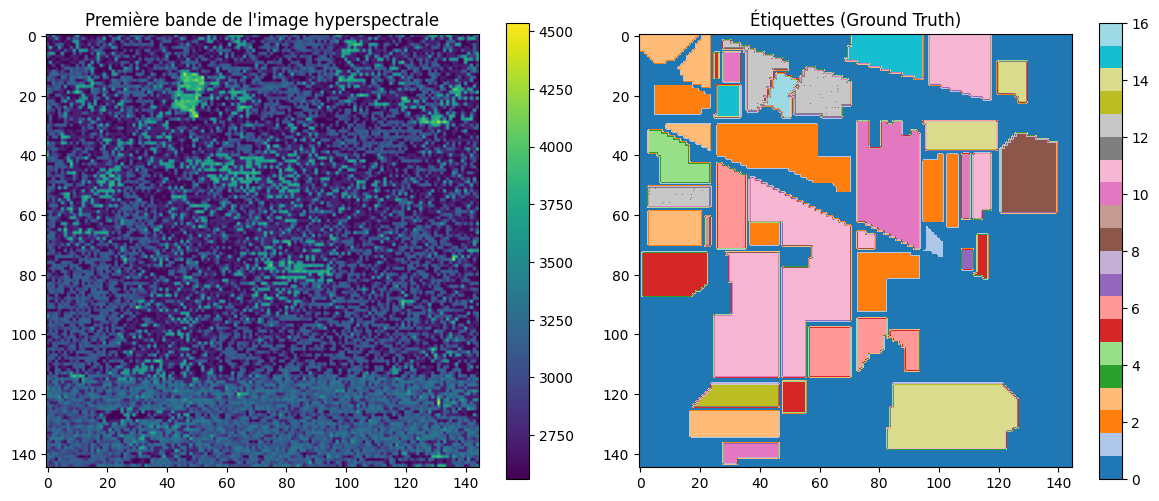


Création du graphe avec {'dilation': 1, 'connectivity_type': '4-connectivity'}...
Forme originale de l'image: (145, 145, 200)
Forme ajustée de l'image: (145, 145, 200)
Utilisation de 20 bandes sélectionnées
Nombre de nœuds: 21025
Nombre d'arêtes: 83520


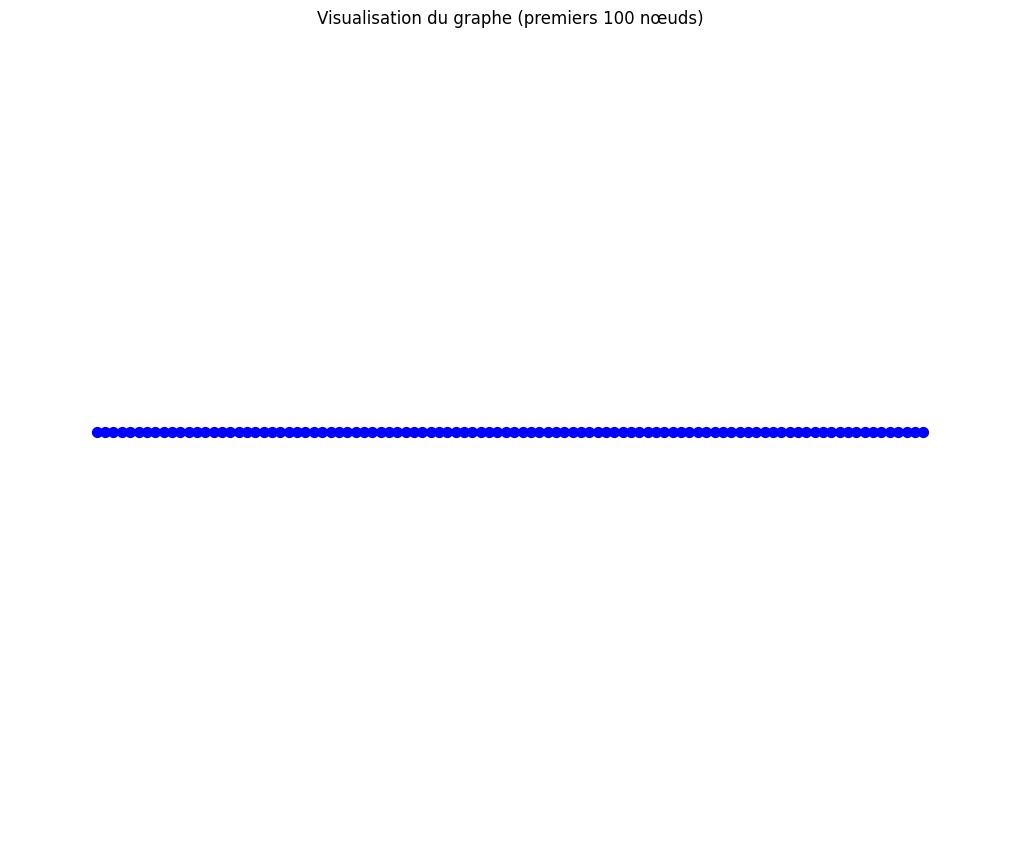

Graphe enregistré dans /kaggle/working/indian_pines_graph_d1_c4_connectivity_equal20bands.pt

Création du graphe avec {'dilation': 1, 'connectivity_type': '8-connectivity'}...
Forme originale de l'image: (145, 145, 200)
Forme ajustée de l'image: (145, 145, 200)
Utilisation de 20 bandes sélectionnées
Nombre de nœuds: 21025
Nombre d'arêtes: 166464


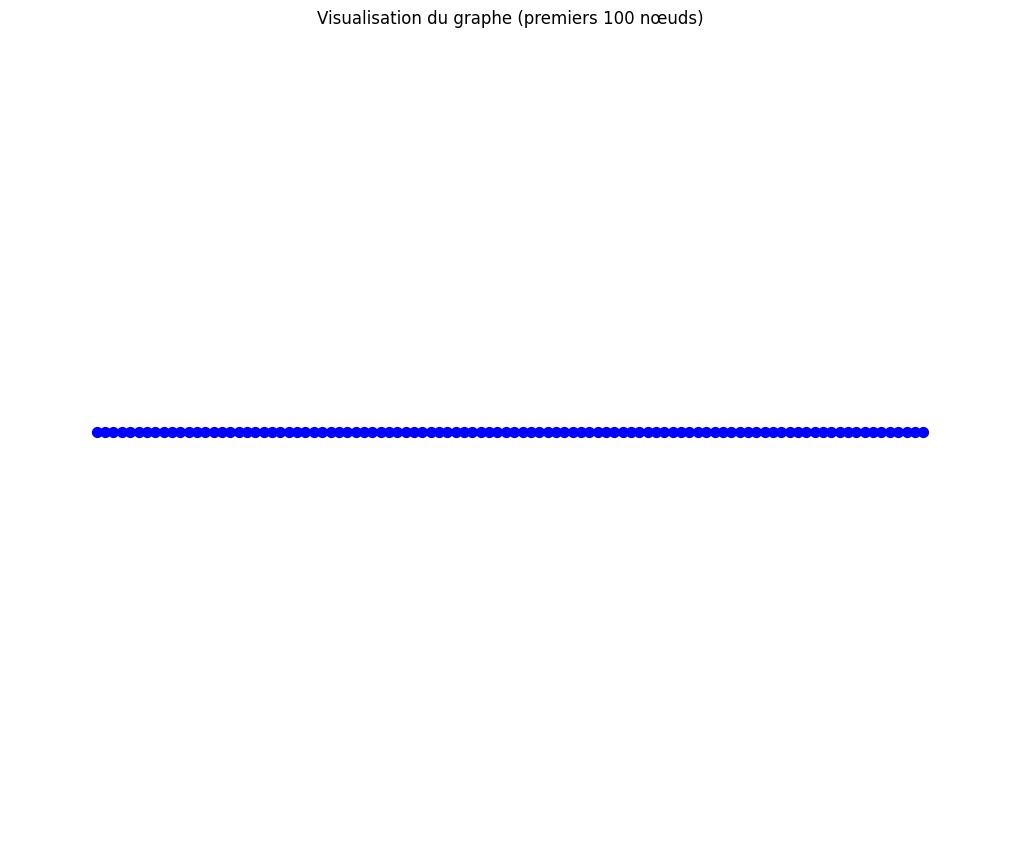

Graphe enregistré dans /kaggle/working/indian_pines_graph_d1_c8_connectivity_equal20bands.pt

Création du graphe avec {'dilation': 2, 'connectivity_type': '4-connectivity'}...
Forme originale de l'image: (145, 145, 200)
Forme ajustée de l'image: (145, 145, 200)
Utilisation de 20 bandes sélectionnées
Nombre de nœuds: 21025
Nombre d'arêtes: 166460


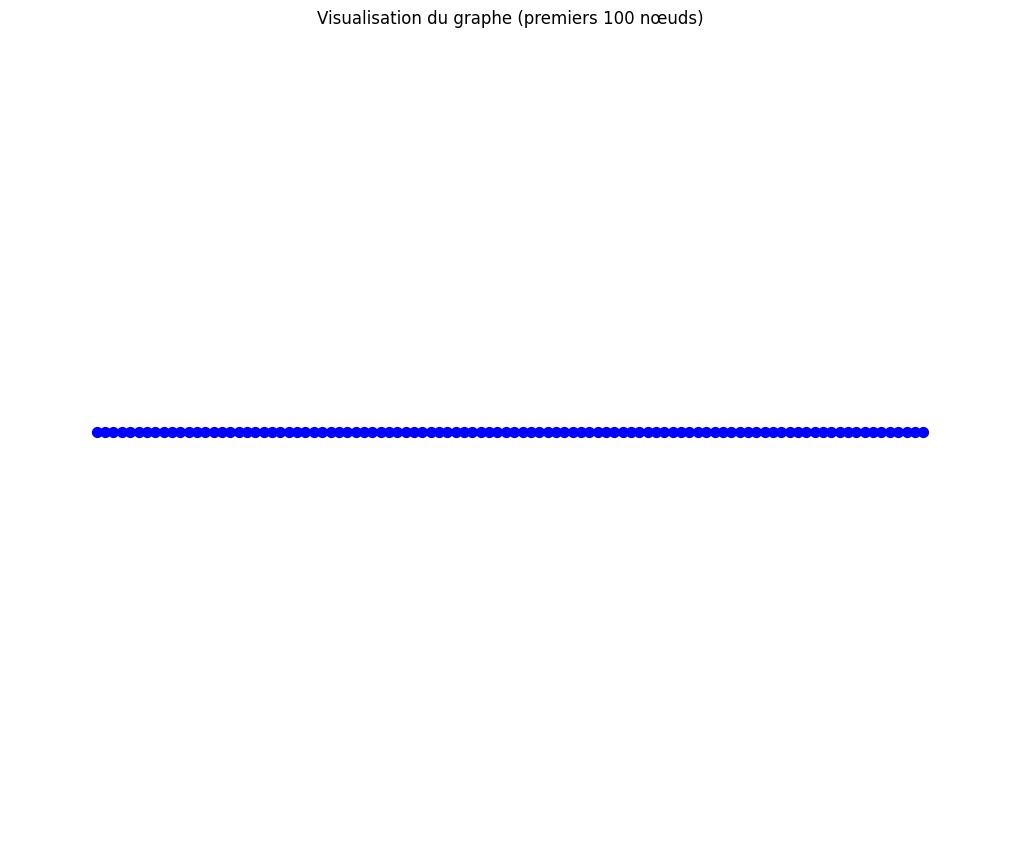

Graphe enregistré dans /kaggle/working/indian_pines_graph_d2_c4_connectivity_equal20bands.pt

Création du graphe avec {'dilation': 2, 'connectivity_type': '8-connectivity'}...
Forme originale de l'image: (145, 145, 200)
Forme ajustée de l'image: (145, 145, 200)
Utilisation de 20 bandes sélectionnées
Nombre de nœuds: 21025
Nombre d'arêtes: 331200


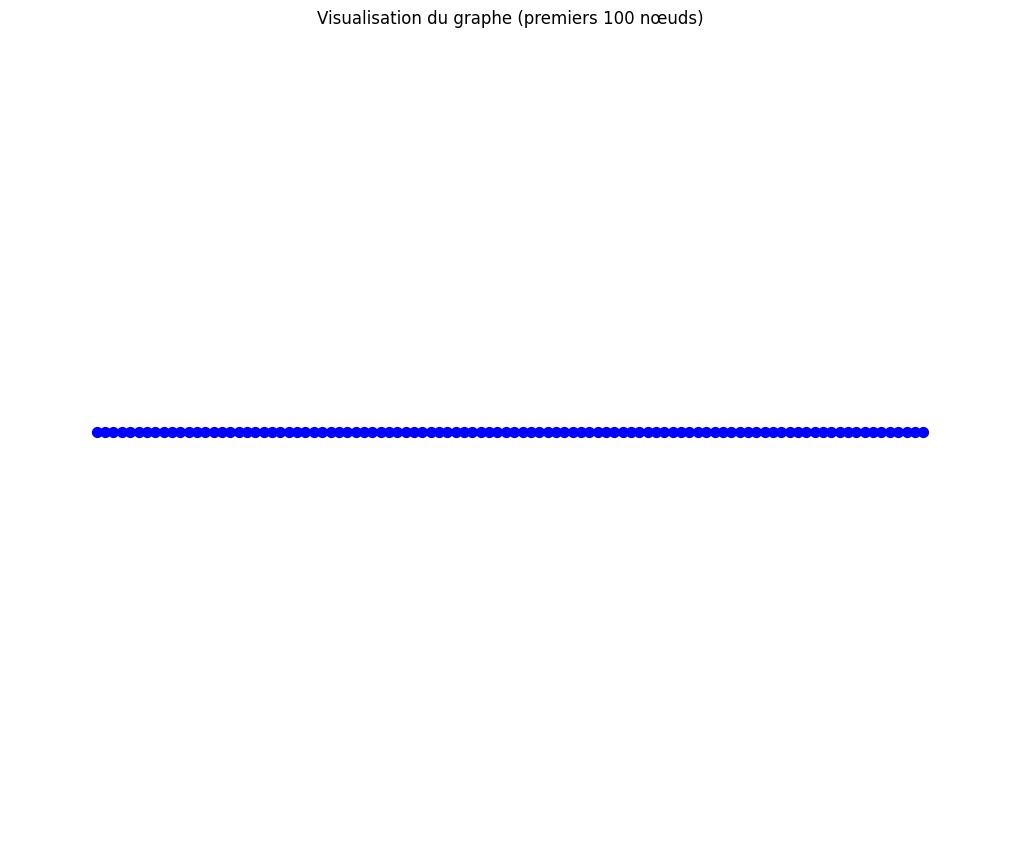

Graphe enregistré dans /kaggle/working/indian_pines_graph_d2_c8_connectivity_equal20bands.pt

Création du graphe avec {'dilation': 3, 'connectivity_type': '4-connectivity'}...
Forme originale de l'image: (145, 145, 200)
Forme ajustée de l'image: (145, 145, 200)
Utilisation de 20 bandes sélectionnées
Nombre de nœuds: 21025
Nombre d'arêtes: 248820


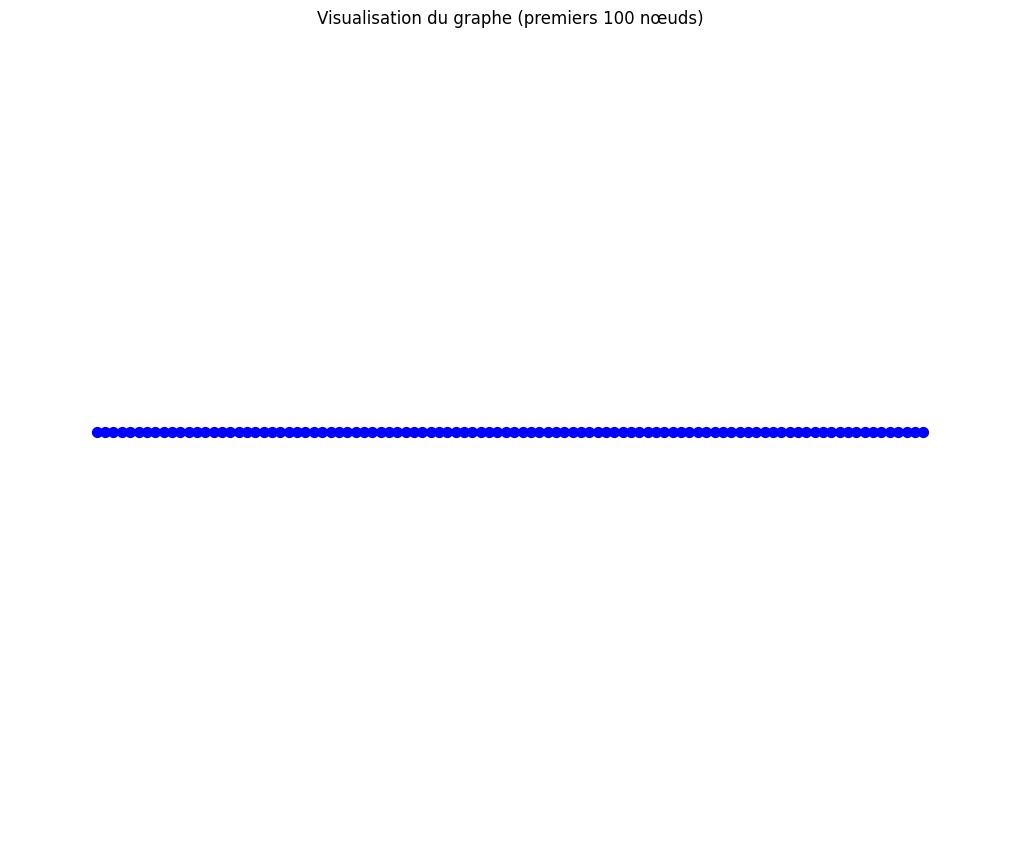

Graphe enregistré dans /kaggle/working/indian_pines_graph_d3_c4_connectivity_equal20bands.pt

Création du graphe avec {'dilation': 3, 'connectivity_type': '8-connectivity'}...
Forme originale de l'image: (145, 145, 200)
Forme ajustée de l'image: (145, 145, 200)
Utilisation de 20 bandes sélectionnées
Nombre de nœuds: 21025
Nombre d'arêtes: 494216


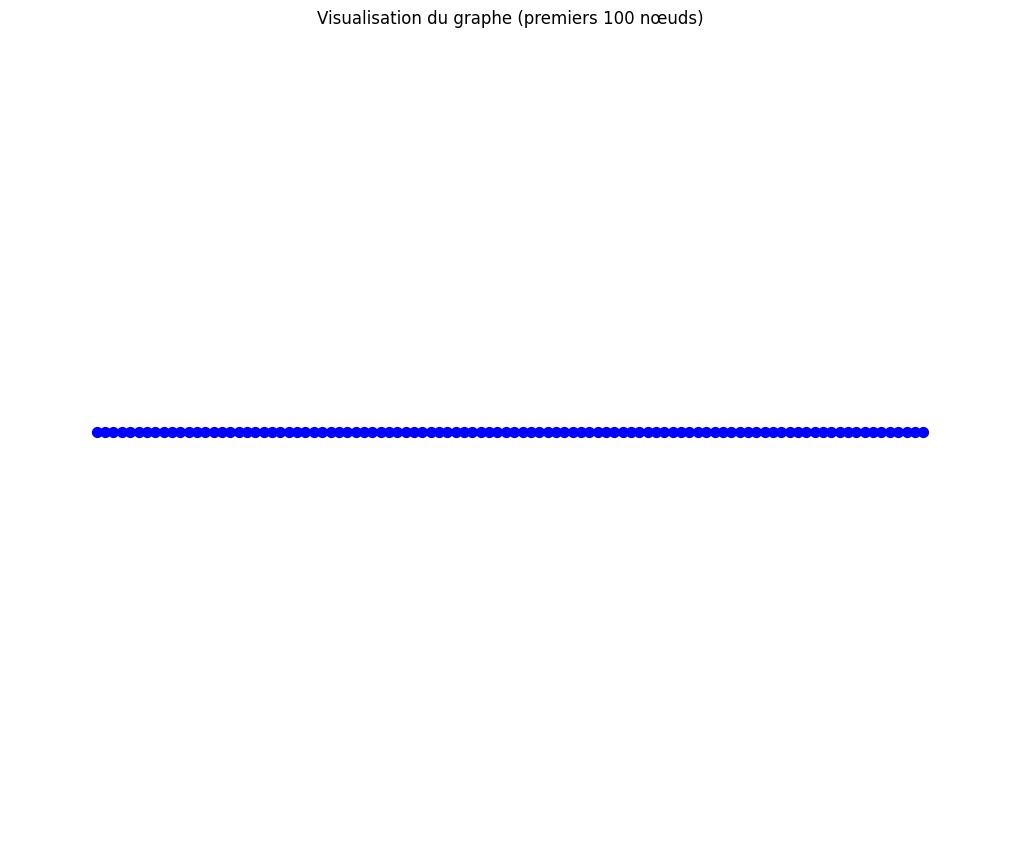

Graphe enregistré dans /kaggle/working/indian_pines_graph_d3_c8_connectivity_equal20bands.pt


In [6]:
# Fonction pour visualiser le graphe (un sous-ensemble pour la clarté)
def visualize_graph(data, height, width, max_nodes=100):
    """
    Visualise un sous-ensemble du graphe pour vérification.
    """
    # Créer un graphe NetworkX à partir des données
    G = nx.Graph()
    
    # Ajouter les nœuds
    for i in range(min(max_nodes, data.num_nodes)):
        G.add_node(i)
     # Ajouter les arêtes (seulement celles entre les nœuds sélectionnés)
    edge_index = data.edge_index.numpy()
    for i in range(edge_index.shape[1]):
        src, dst = edge_index[0, i], edge_index[1, i]
        if src < max_nodes and dst < max_nodes:
            G.add_edge(src, dst)
    # Créer un dictionnaire de positions pour la visualisation
    pos = {}
    for i in range(min(max_nodes, height * width)):
        row, col = i // width, i % width
        pos[i] = (col, -row)  # Inverser les y pour que l'origine soit en haut à gauche
    
    # Visualiser le graphe
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, node_size=50, node_color='blue', with_labels=False)
    plt.title(f"Visualisation du graphe (premiers {max_nodes} nœuds)")
    plt.show()
    
# Visualiser l'image et les étiquettes
def visualize_data(image, labels):
    """
    Visualise l'image hyperspectrale et les étiquettes.
    """
    # Afficher une bande de l'image
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image[:, :, 0], cmap='viridis')
    plt.title("Première bande de l'image hyperspectrale")
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    plt.imshow(labels, cmap='tab20')
    plt.title("Étiquettes (Ground Truth)")
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()
 
# Exemple d'utilisation
def main():
    # Installation des packages nécessaires si non disponibles
    try:
        import torch_geometric
    except ImportError:
        print("Installation de PyTorch Geometric...")
        !pip install torch-geometric
    
    # Vérification des fichiers
    corrected_file = os.path.join(dataset_path, 'Indian_pines_corrected.mat')
    gt_file = os.path.join(dataset_path, 'Indian_pines_gt.mat')
    
    if not os.path.exists(corrected_file):
        print(f"Attention: Le fichier {corrected_file} n'existe pas. Vérifiez le chemin du dataset.")
    if not os.path.exists(gt_file):
        print(f"Attention: Le fichier {gt_file} n'existe pas. Vérifiez le chemin du dataset.")
    
    # Chargement des données
    print("Chargement des données Indian Pines...")
    image, gt = load_indian_pines()
    
    print(f"Forme de l'image: {image.shape}")
    print(f"Forme des étiquettes: {gt.shape}")
    
    # Utilisation des 20 meilleures bandes issues de l'analyse Equal Spacing
    selected_bands = [0, 19, 27, 38, 44, 52, 60, 74, 84, 93, 102, 116, 125, 130, 142, 159, 163, 172, 180, 199]
    
    print("Bandes sélectionnées par méthode Equal Spacing (une par segment):")
    for i, band in enumerate(selected_bands):
        print(f"  Segment {i+1}: Bande {band}")
    
    # Visualiser les données
    visualize_data(image, gt)
    
    # Créer des graphes avec différentes configurations
    configs = [
        {'dilation': 1, 'connectivity_type': '4-connectivity'},
        {'dilation': 1, 'connectivity_type': '8-connectivity'},
        {'dilation': 2, 'connectivity_type': '4-connectivity'},
        {'dilation': 2, 'connectivity_type': '8-connectivity'},
        {'dilation': 3, 'connectivity_type': '4-connectivity'},
        {'dilation': 3, 'connectivity_type': '8-connectivity'}
    ]
    
    for config in configs:
        print(f"\nCréation du graphe avec {config}...")
        # Utiliser uniquement les bandes sélectionnées
        data = create_hyperspectral_graph(image, gt, selected_bands=selected_bands, **config)
        
        print(f"Nombre de nœuds: {data.num_nodes}")
        print(f"Nombre d'arêtes: {data.edge_index.shape[1]}")
        
        # Visualiser un sous-ensemble du graphe
        visualize_graph(data, image.shape[0], image.shape[1])
        
        # Enregistrer le graphe avec un nom indiquant l'utilisation des bandes sélectionnées
        output_file = os.path.join(
            output_path, 
            f"indian_pines_graph_d{config['dilation']}_c{config['connectivity_type'].replace('-', '_')}_equal20bands.pt"
        )
        torch.save(data, output_file)
        print(f"Graphe enregistré dans {output_file}")

if __name__ == "__main__":
    main()

## Évaluation Multi-échelle de Réseaux GCN sur Graphes: Analyse Comparative des Performances en Fonction de la Dilation et de la Connectivité (IOU)

Utilisation de: cuda

Traitement du graphe: indian_pines_graph_d1_c4_connectivity_equal20bands.pt
Évaluation du graphe: indian_pines_graph_d1_c4_connectivity_equal20bands.pt
Erreur méthode 1: cannot access local variable 'torch' where it is not associated with a value
Nombre de caractéristiques: 20
Nombre de classes: 17
Répartition des données:
  Entraînement: 14717 pixels (70.0%)
  Validation:   2103 pixels (10.0%)
  Test:         4205 pixels (20.0%)

Distribution des classes dans les ensembles:
  Classes totales: 17
  Classes dans l'ensemble d'entraînement: 17
  Classes dans l'ensemble de validation: 17
  Classes dans l'ensemble de test: 17
Toutes les classes sont correctement représentées dans tous les ensembles.
Début de l'entraînement...
Epoch: 1/150, Train Loss: 2.8040, Val Loss: 2.4647, Val Accuracy: 0.4964
Epoch 1: Nouvelle meilleure précision de validation: 0.4964
Epoch 2: Nouvelle meilleure précision de validation: 0.5259
Epoch 3: Nouvelle meilleure précision de validation: 0

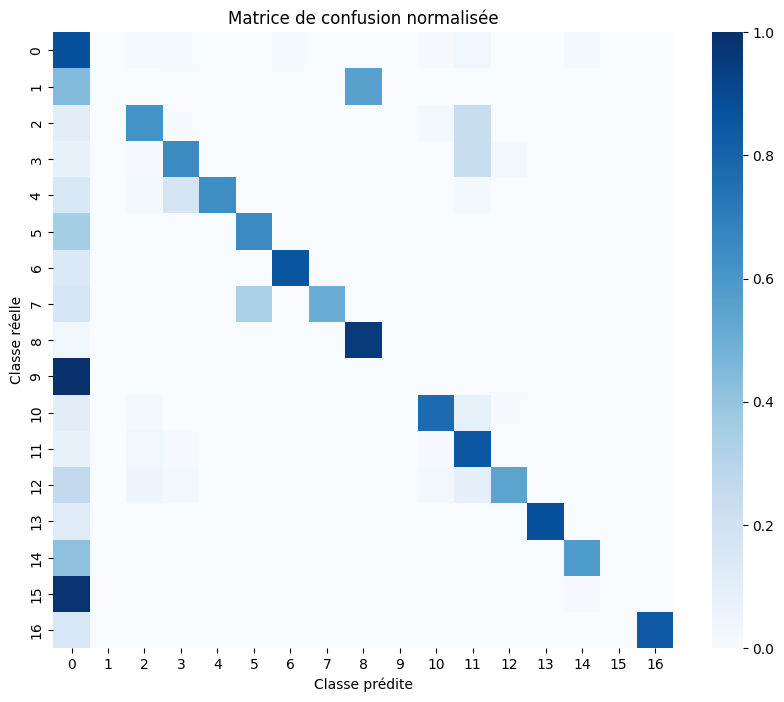

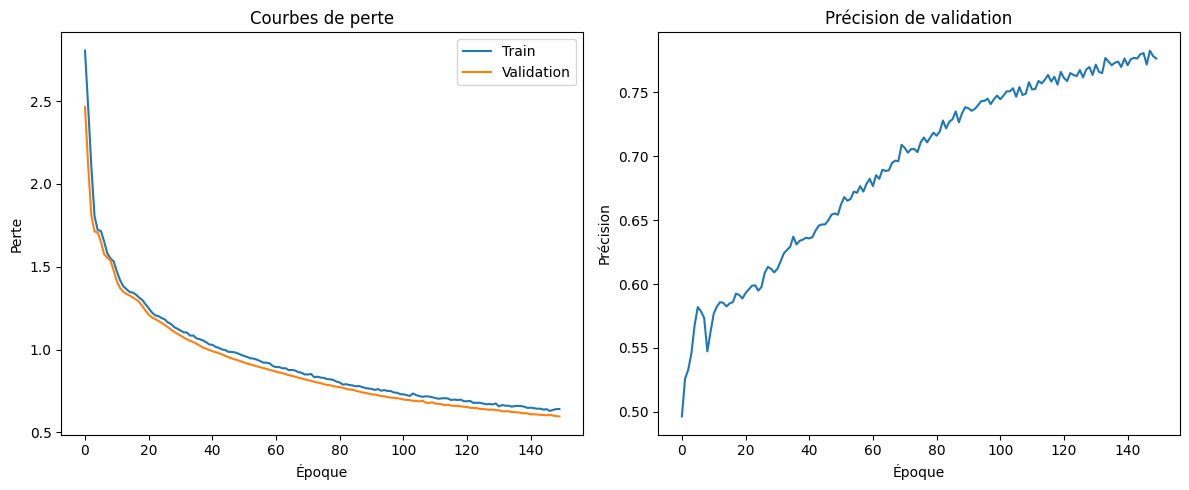

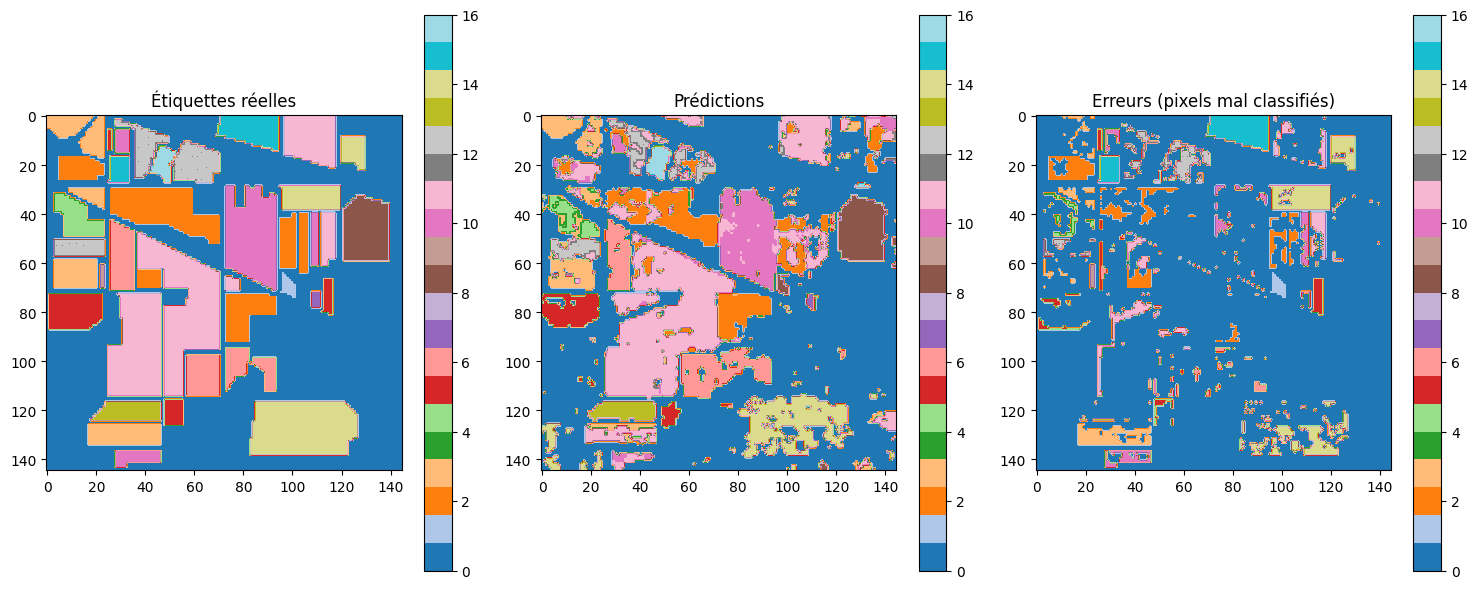

Taux d'erreur global: 0.2078 (20.78%)

Traitement du graphe: indian_pines_graph_d1_c8_connectivity_equal20bands.pt
Évaluation du graphe: indian_pines_graph_d1_c8_connectivity_equal20bands.pt
Erreur méthode 1: cannot access local variable 'torch' where it is not associated with a value
Nombre de caractéristiques: 20
Nombre de classes: 17
Répartition des données:
  Entraînement: 14717 pixels (70.0%)
  Validation:   2103 pixels (10.0%)
  Test:         4205 pixels (20.0%)

Distribution des classes dans les ensembles:
  Classes totales: 17
  Classes dans l'ensemble d'entraînement: 17
  Classes dans l'ensemble de validation: 17
  Classes dans l'ensemble de test: 17
Toutes les classes sont correctement représentées dans tous les ensembles.
Début de l'entraînement...
Epoch: 1/150, Train Loss: 2.8112, Val Loss: 2.4280, Val Accuracy: 0.5630
Epoch 1: Nouvelle meilleure précision de validation: 0.5630
Epoch 2: Nouvelle meilleure précision de validation: 0.5806
Epoch 3: Nouvelle meilleure précision

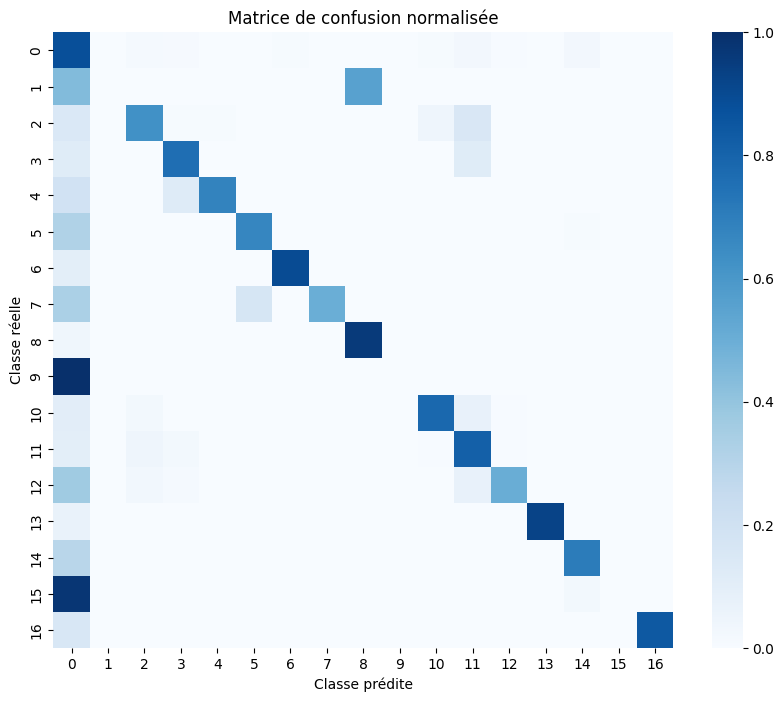

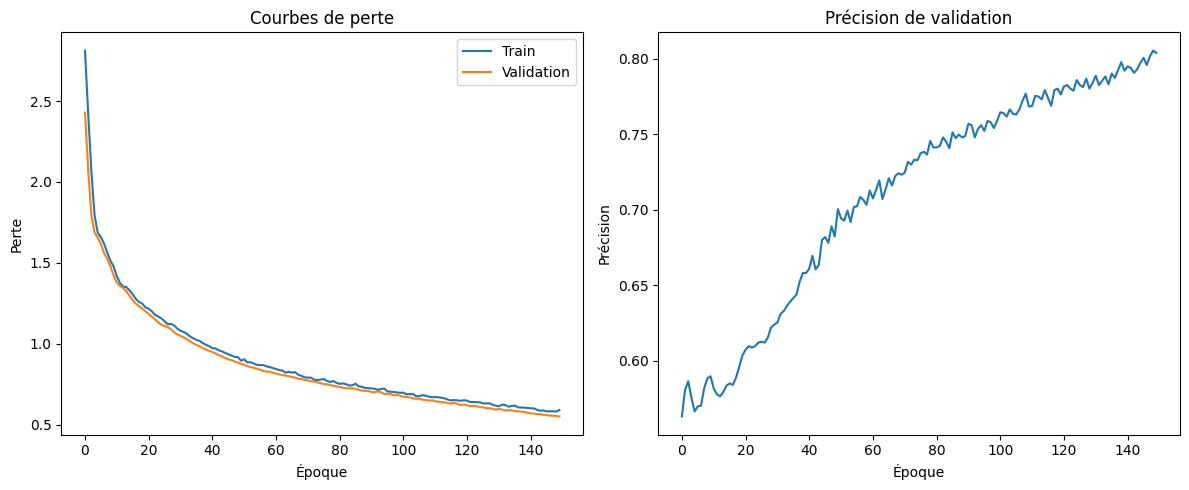

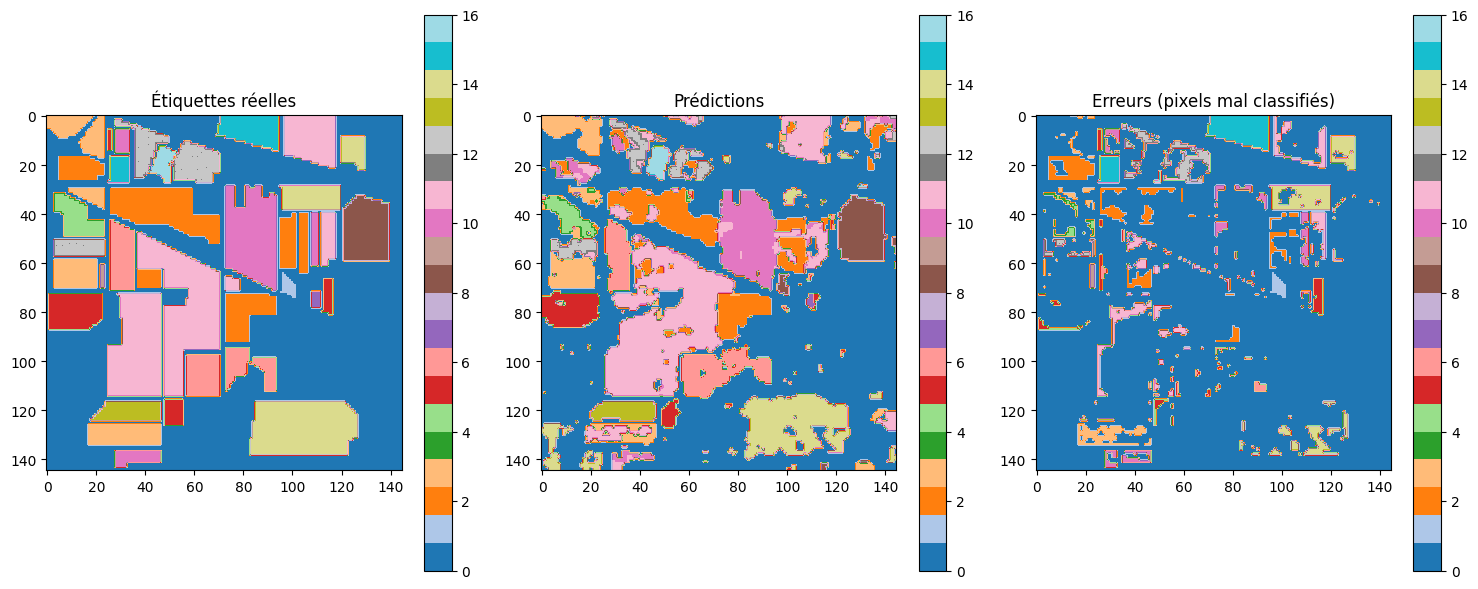

Taux d'erreur global: 0.1932 (19.32%)

Traitement du graphe: indian_pines_graph_d2_c4_connectivity_equal20bands.pt
Évaluation du graphe: indian_pines_graph_d2_c4_connectivity_equal20bands.pt
Erreur méthode 1: cannot access local variable 'torch' where it is not associated with a value
Nombre de caractéristiques: 20
Nombre de classes: 17
Répartition des données:
  Entraînement: 14717 pixels (70.0%)
  Validation:   2103 pixels (10.0%)
  Test:         4205 pixels (20.0%)

Distribution des classes dans les ensembles:
  Classes totales: 17
  Classes dans l'ensemble d'entraînement: 17
  Classes dans l'ensemble de validation: 17
  Classes dans l'ensemble de test: 17
Toutes les classes sont correctement représentées dans tous les ensembles.
Début de l'entraînement...
Epoch: 1/150, Train Loss: 2.8613, Val Loss: 2.5388, Val Accuracy: 0.4085
Epoch 1: Nouvelle meilleure précision de validation: 0.4085
Epoch 2: Nouvelle meilleure précision de validation: 0.5502
Epoch 3: Nouvelle meilleure précision

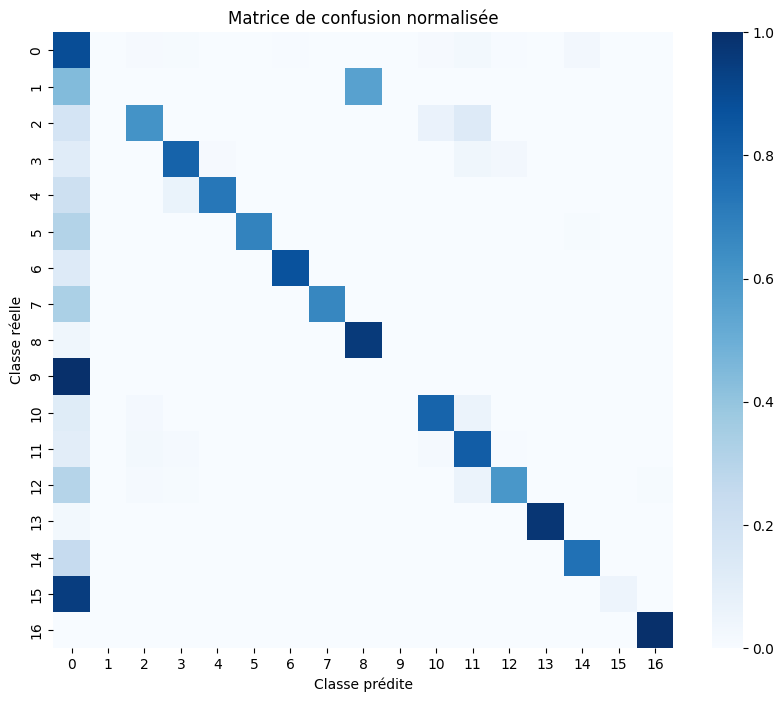

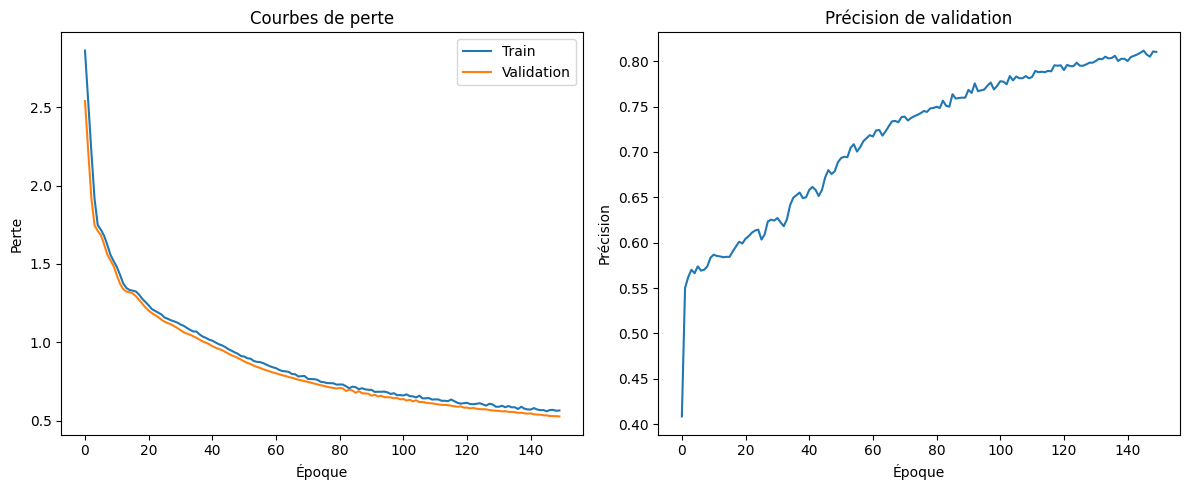

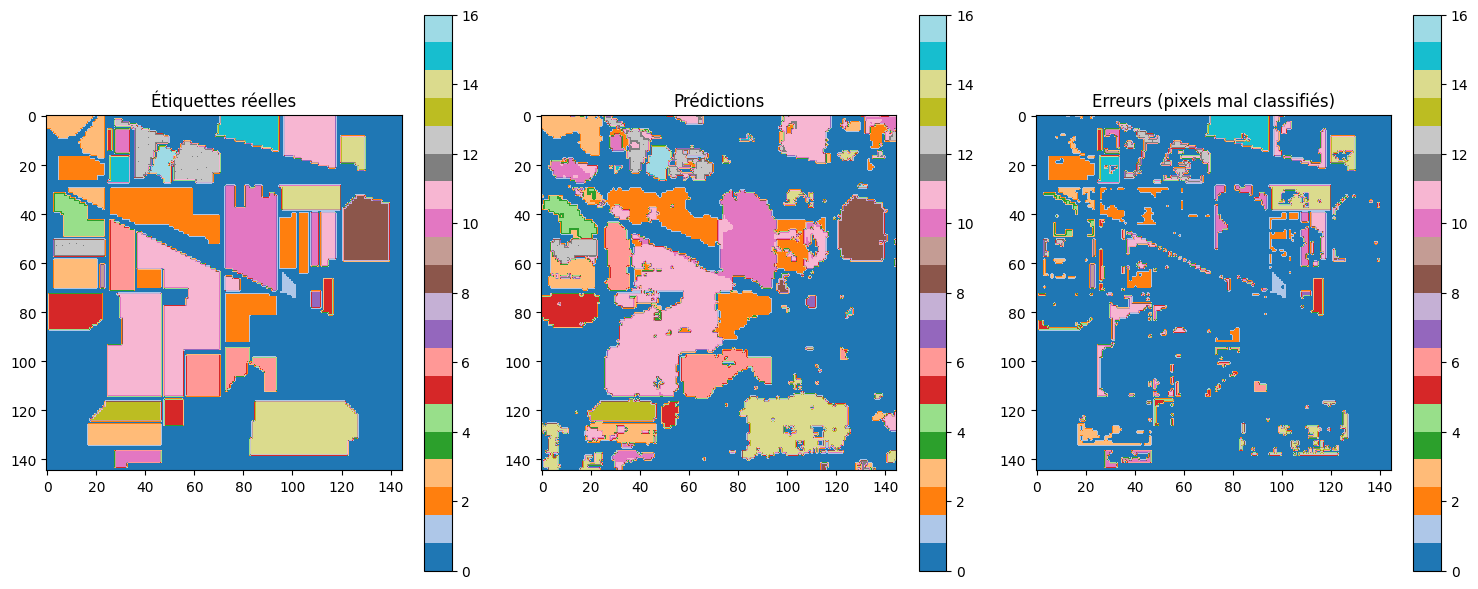

Taux d'erreur global: 0.1845 (18.45%)

Traitement du graphe: indian_pines_graph_d2_c8_connectivity_equal20bands.pt
Évaluation du graphe: indian_pines_graph_d2_c8_connectivity_equal20bands.pt
Erreur méthode 1: cannot access local variable 'torch' where it is not associated with a value
Nombre de caractéristiques: 20
Nombre de classes: 17
Répartition des données:
  Entraînement: 14717 pixels (70.0%)
  Validation:   2103 pixels (10.0%)
  Test:         4205 pixels (20.0%)

Distribution des classes dans les ensembles:
  Classes totales: 17
  Classes dans l'ensemble d'entraînement: 17
  Classes dans l'ensemble de validation: 17
  Classes dans l'ensemble de test: 17
Toutes les classes sont correctement représentées dans tous les ensembles.
Début de l'entraînement...
Epoch: 1/150, Train Loss: 2.9031, Val Loss: 2.5941, Val Accuracy: 0.5235
Epoch 1: Nouvelle meilleure précision de validation: 0.5235
Epoch 2: Nouvelle meilleure précision de validation: 0.5568
Epoch 5: Nouvelle meilleure précision

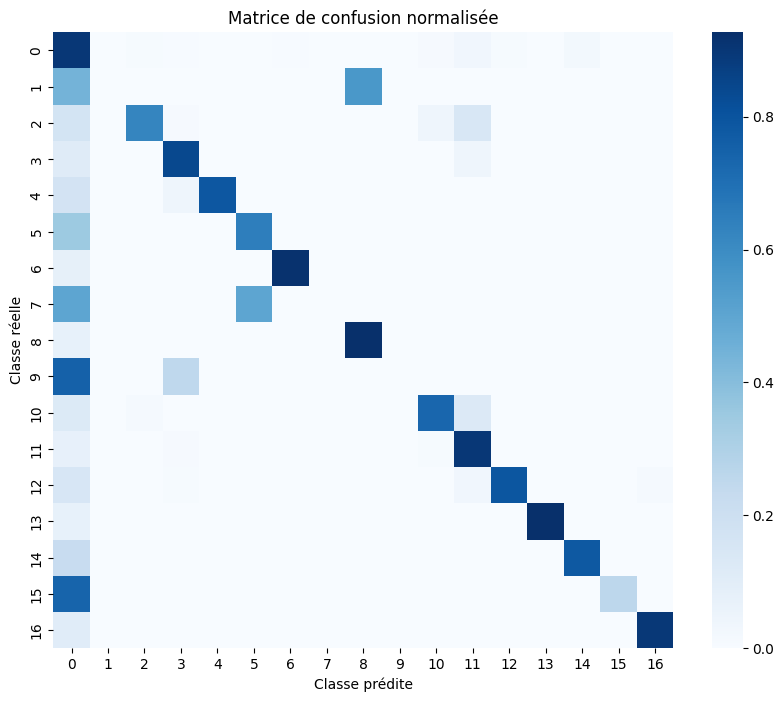

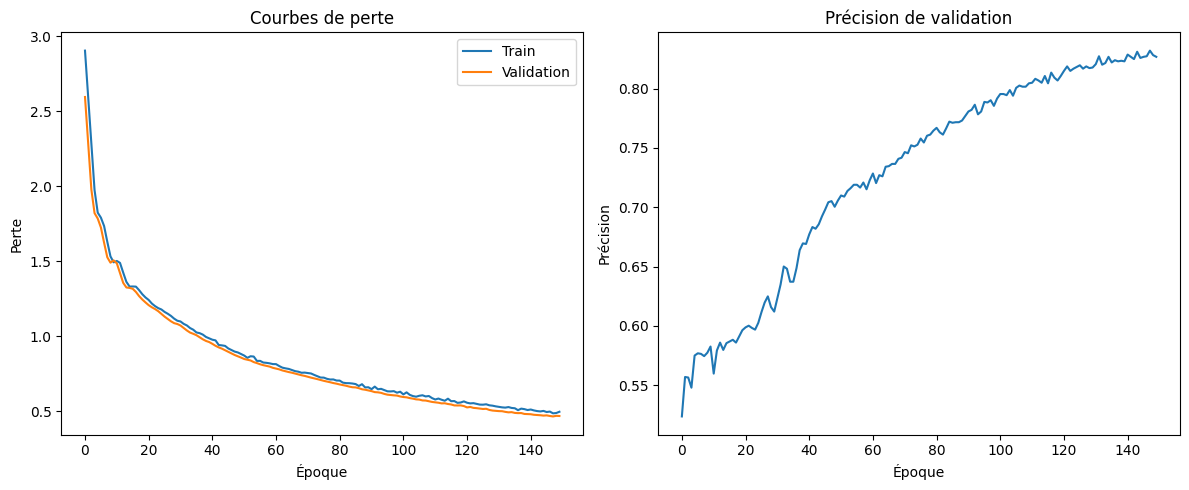

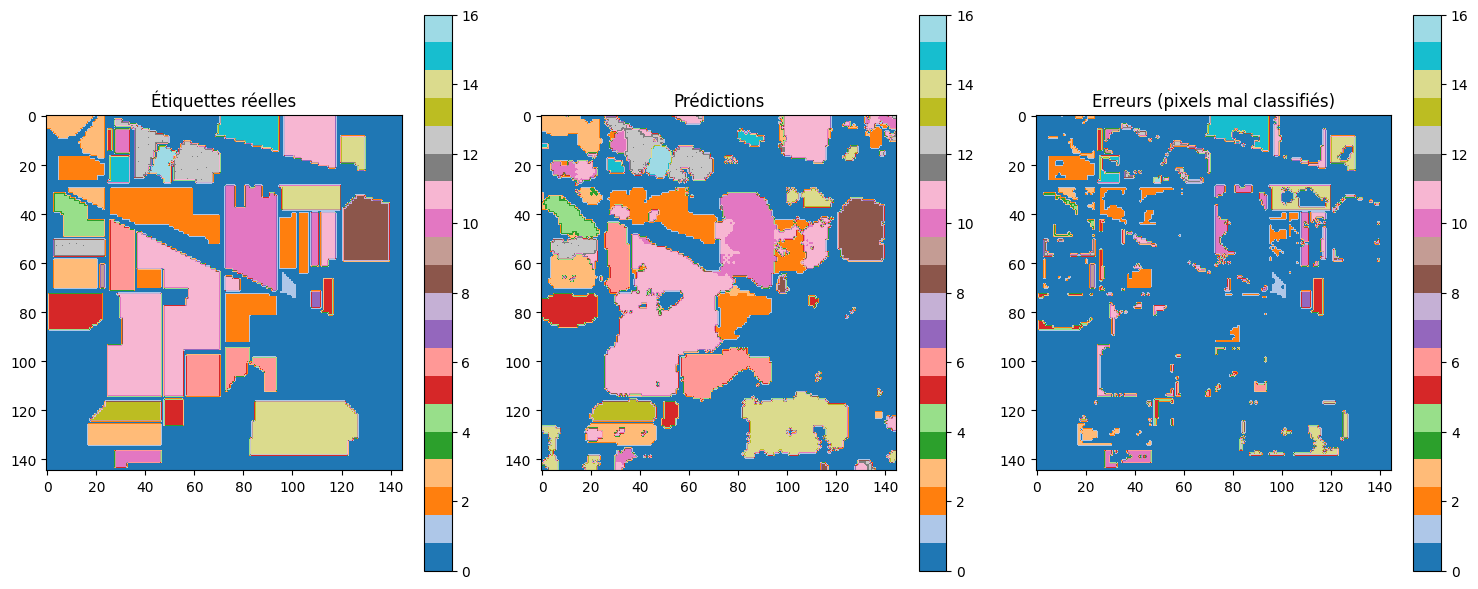

Taux d'erreur global: 0.1629 (16.29%)

Traitement du graphe: indian_pines_graph_d3_c4_connectivity_equal20bands.pt
Évaluation du graphe: indian_pines_graph_d3_c4_connectivity_equal20bands.pt
Erreur méthode 1: cannot access local variable 'torch' where it is not associated with a value
Nombre de caractéristiques: 20
Nombre de classes: 17
Répartition des données:
  Entraînement: 14717 pixels (70.0%)
  Validation:   2103 pixels (10.0%)
  Test:         4205 pixels (20.0%)

Distribution des classes dans les ensembles:
  Classes totales: 17
  Classes dans l'ensemble d'entraînement: 17
  Classes dans l'ensemble de validation: 17
  Classes dans l'ensemble de test: 17
Toutes les classes sont correctement représentées dans tous les ensembles.
Début de l'entraînement...
Epoch: 1/150, Train Loss: 2.8903, Val Loss: 2.6130, Val Accuracy: 0.4922
Epoch 1: Nouvelle meilleure précision de validation: 0.4922
Epoch 2: Nouvelle meilleure précision de validation: 0.5321
Epoch 5: Nouvelle meilleure précision

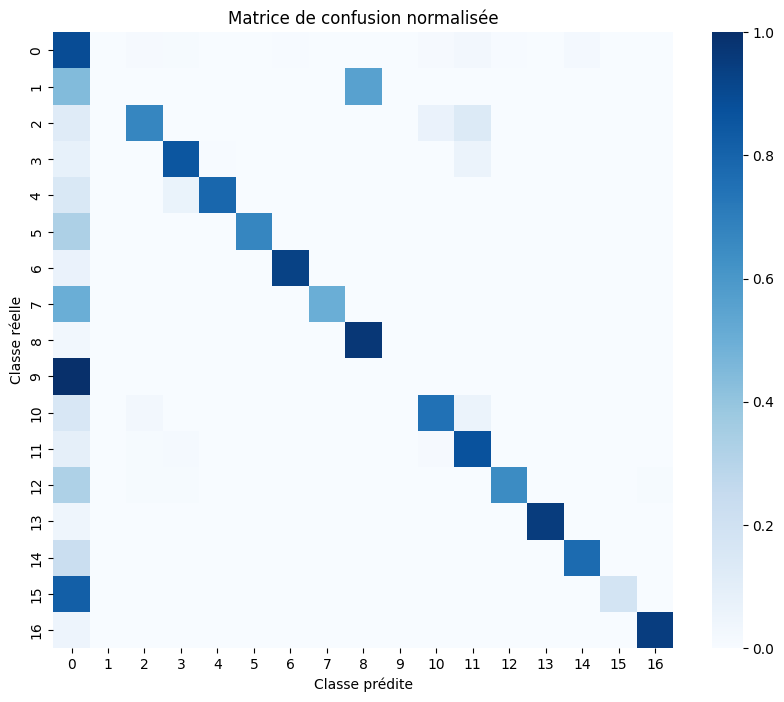

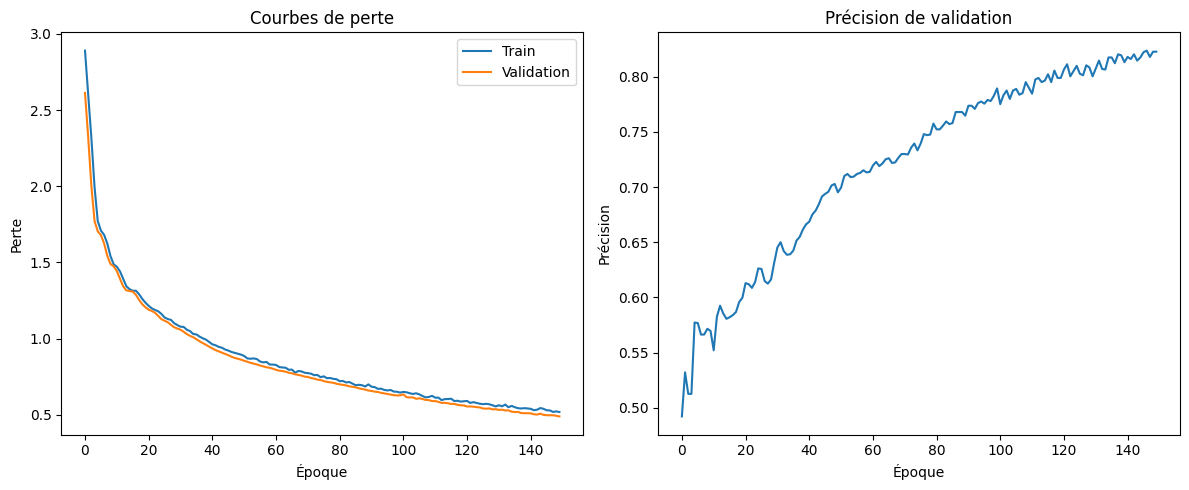

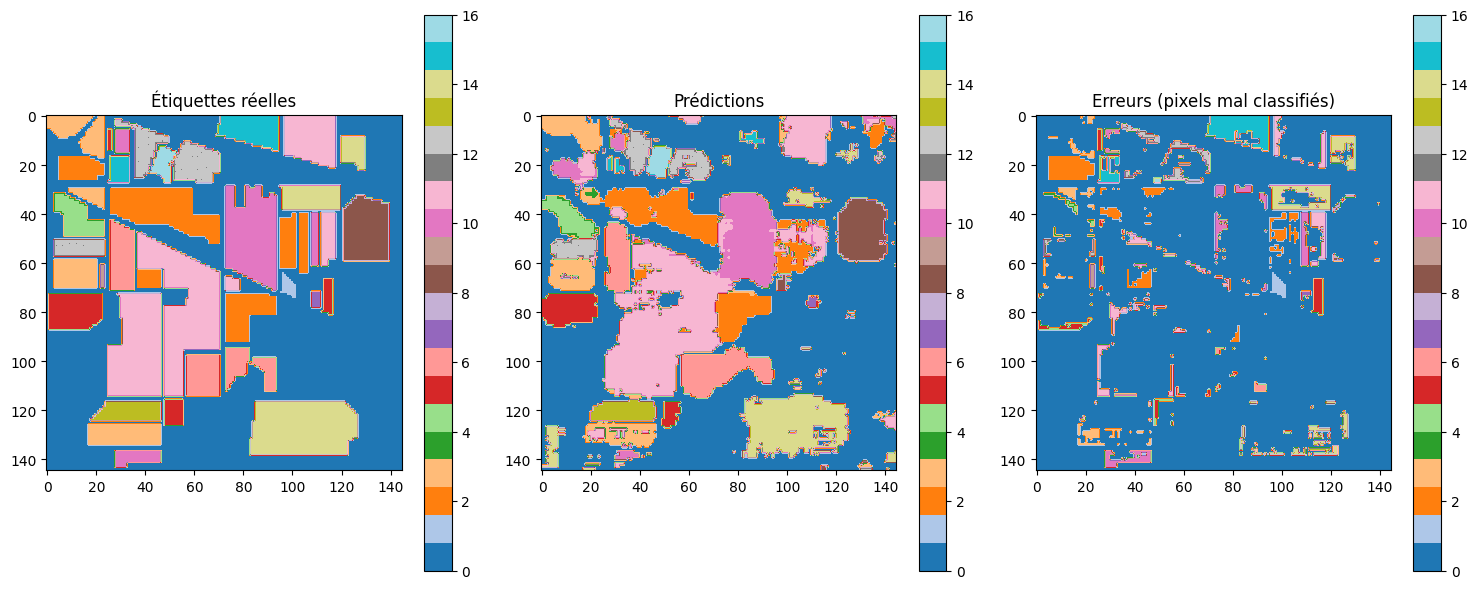

Taux d'erreur global: 0.1715 (17.15%)

Traitement du graphe: indian_pines_graph_d3_c8_connectivity_equal20bands.pt
Évaluation du graphe: indian_pines_graph_d3_c8_connectivity_equal20bands.pt
Erreur méthode 1: cannot access local variable 'torch' where it is not associated with a value
Nombre de caractéristiques: 20
Nombre de classes: 17
Répartition des données:
  Entraînement: 14717 pixels (70.0%)
  Validation:   2103 pixels (10.0%)
  Test:         4205 pixels (20.0%)

Distribution des classes dans les ensembles:
  Classes totales: 17
  Classes dans l'ensemble d'entraînement: 17
  Classes dans l'ensemble de validation: 17
  Classes dans l'ensemble de test: 17
Toutes les classes sont correctement représentées dans tous les ensembles.
Début de l'entraînement...
Epoch: 1/150, Train Loss: 2.9067, Val Loss: 2.6160, Val Accuracy: 0.4061
Epoch 1: Nouvelle meilleure précision de validation: 0.4061
Epoch 2: Nouvelle meilleure précision de validation: 0.5411
Epoch 3: Nouvelle meilleure précision

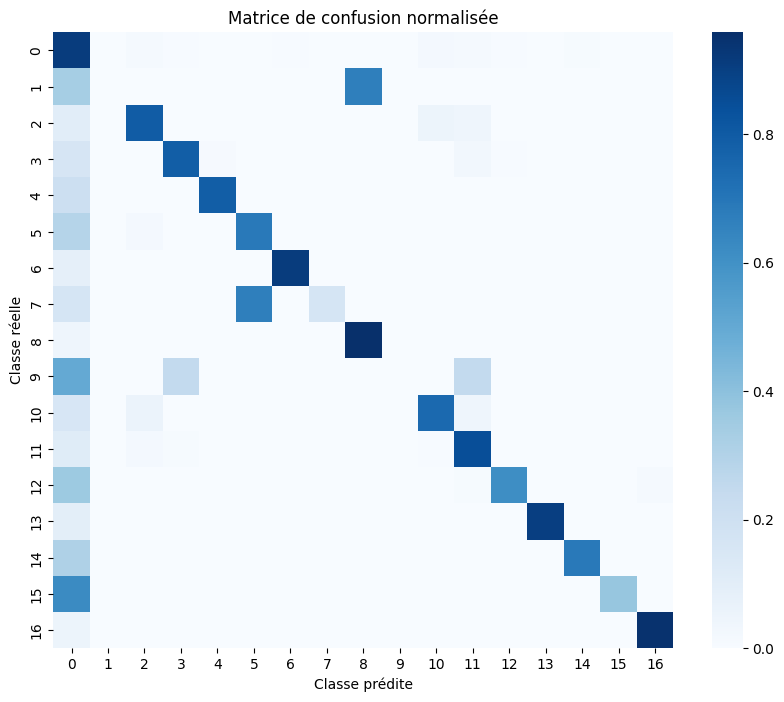

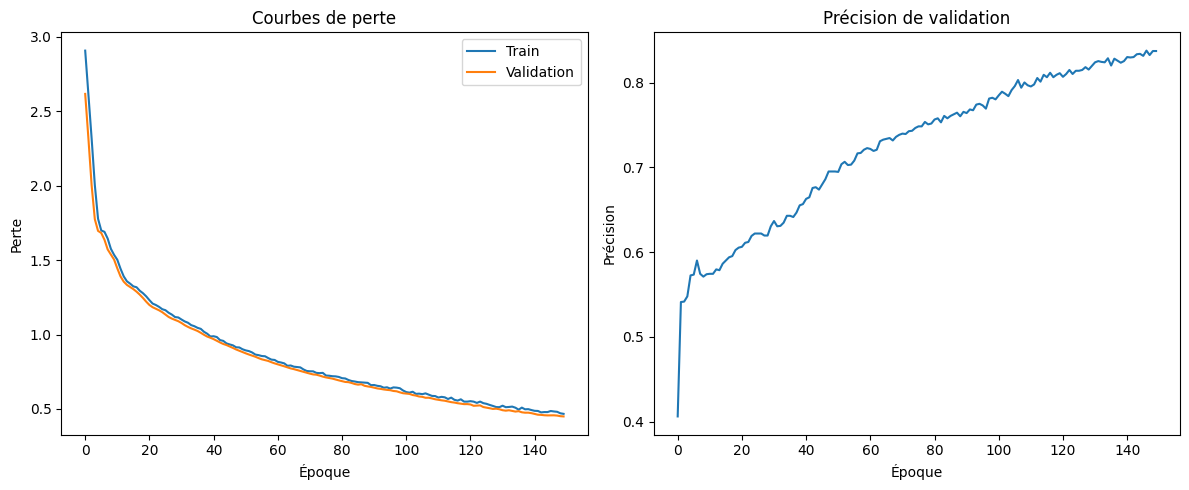

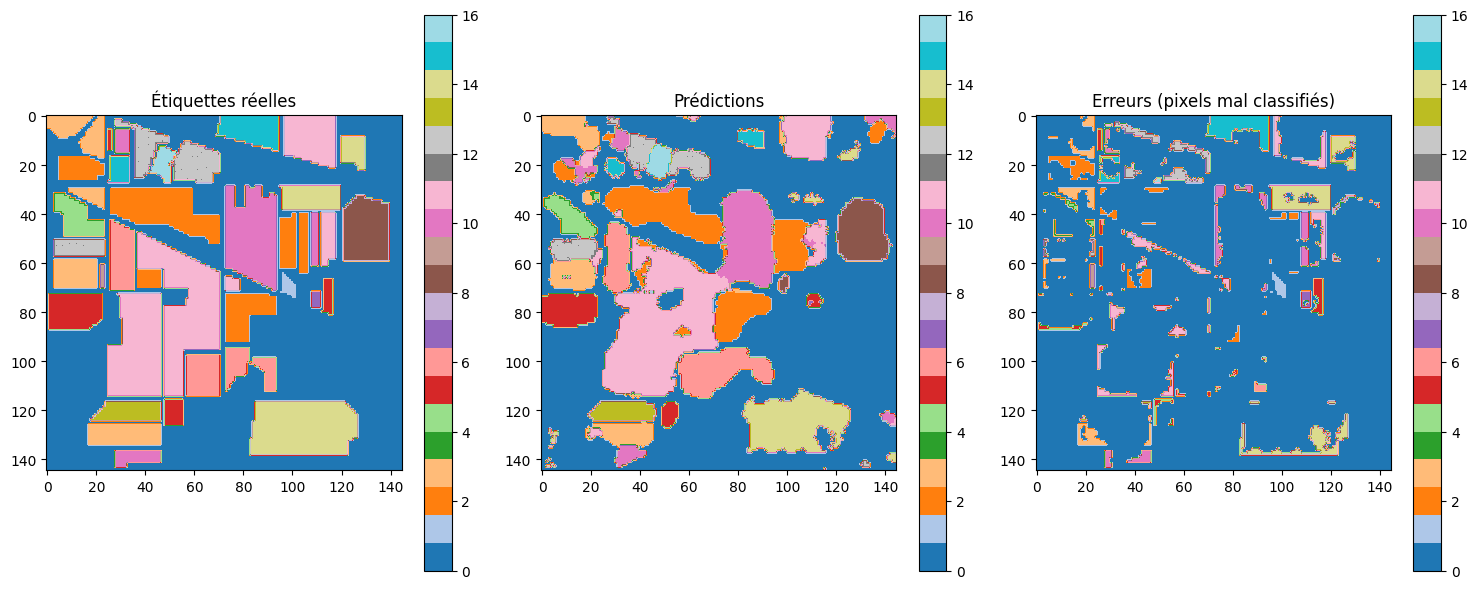

Taux d'erreur global: 0.1583 (15.83%)

Tableau comparatif des résultats:
                                              Graphe    Connectivité  \
0  indian_pines_graph_d1_c4_connectivity_equal20b...  4-connectivity   
1  indian_pines_graph_d1_c8_connectivity_equal20b...  8-connectivity   
2  indian_pines_graph_d2_c4_connectivity_equal20b...  4-connectivity   
3  indian_pines_graph_d2_c8_connectivity_equal20b...  8-connectivity   
4  indian_pines_graph_d3_c4_connectivity_equal20b...  4-connectivity   
5  indian_pines_graph_d3_c8_connectivity_equal20b...  8-connectivity   

   Dilation  F1 Score  F1 Score (macro)  Accuracy  \
0         1  0.777927          0.632716  0.789061   
1         1  0.791555          0.648670  0.802616   
2         2  0.806609          0.678711  0.815933   
3         2  0.833010          0.666569  0.839239   
4         3  0.826486          0.691688  0.833294   
5         3  0.837367          0.685464  0.842331   

   Meilleure précision validation  
0             

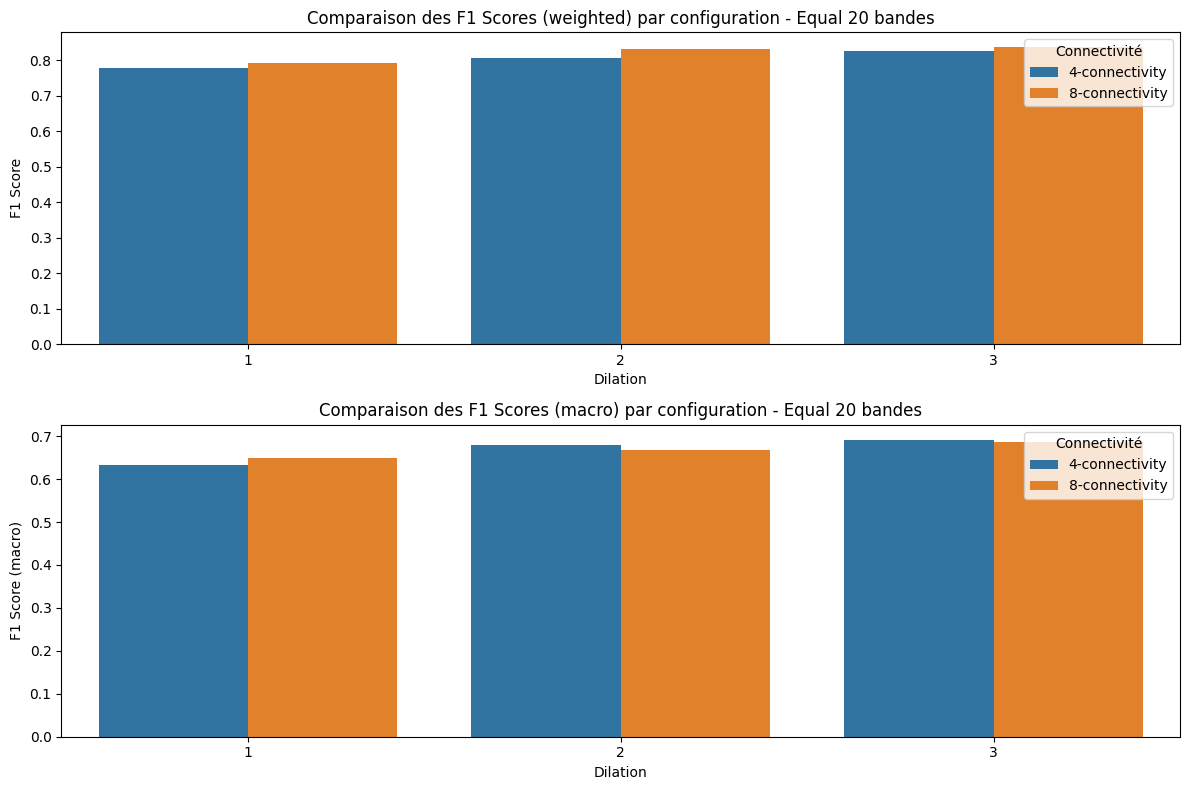

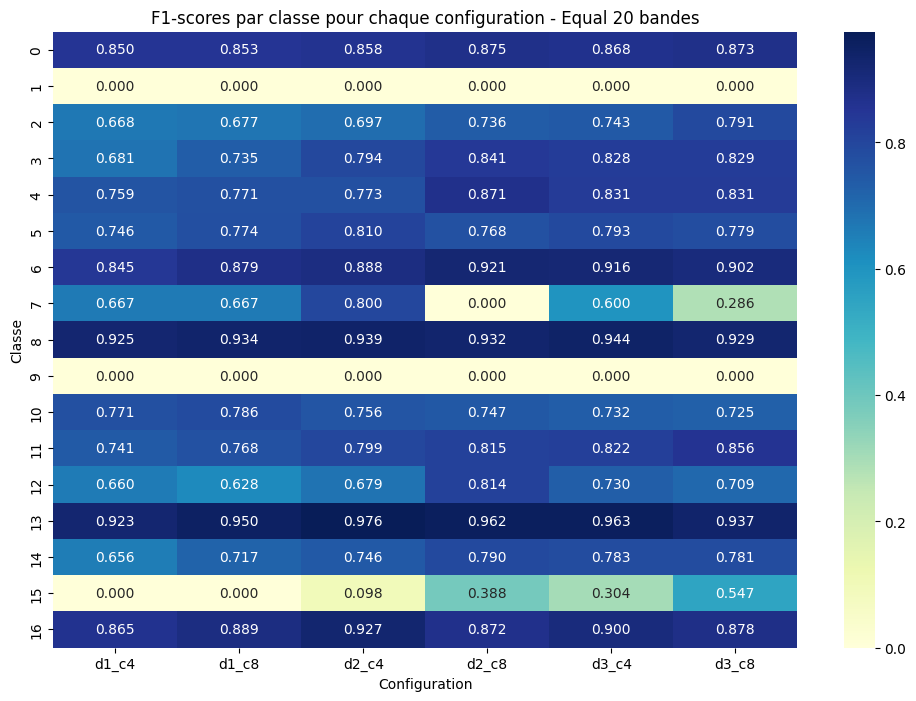

In [7]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# Essayer d'importer DataEdgeAttr si disponible
try:
    from torch_geometric.data.data import DataEdgeAttr
except ImportError:
    print("DataEdgeAttr n'est pas disponible dans cette version de PyTorch Geometric")

# Définir une seed fixe pour la reproductibilité
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Chemins
dataset_path = "/kaggle/input/gcn-dataset"
output_path = "/kaggle/working/"

# Définition du modèle GCN
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels=64):
        super(GCN, self).__init__()
        # Première couche de convolution de graphe
        self.conv1 = GCNConv(num_features, hidden_channels)
        # Seconde couche de convolution de graphe
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        # Couche de classification
        self.lin = nn.Linear(hidden_channels, num_classes)
    
    def forward(self, x, edge_index, batch=None):
        # Premier passage de convolution de graphe
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Second passage de convolution de graphe
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        
        # Si un batch est fourni (pour les graphes multiples), faire un pooling global
        if batch is not None:
            x = global_mean_pool(x, batch)
        
        # Classification
        x = self.lin(x)
        
        return x

def train_with_validation(graph_path, val_size=0.1, test_size=0.2, epochs=100, patience=20, 
                         lr=0.01, device='cuda', include_background=True):
    """
    Entraîne un modèle GCN avec des ensembles d'entraînement, de validation et de test,
    en s'assurant que toutes les classes sont représentées dans chaque ensemble.
    
    Args:
        graph_path: Chemin vers le fichier du graphe
        val_size: Proportion des données pour la validation (par défaut: 0.1)
        test_size: Proportion des données pour le test (par défaut: 0.2)
        epochs: Nombre maximal d'époques d'entraînement
        patience: Nombre d'époques à attendre avant l'arrêt précoce
        lr: Taux d'apprentissage
        device: Appareil à utiliser (cuda/cpu)
        include_background: Inclure ou non la classe de fond (0)
    
    Returns:
        model: Le modèle entraîné
        results: Un dictionnaire avec les métriques d'évaluation
    """
    print(f"Évaluation du graphe: {os.path.basename(graph_path)}")
    
    # Charger le graphe avec différentes méthodes
    try:
        # Méthode 1: Essayer d'abord avec weights_only=False
        data = torch.load(graph_path, weights_only=False)
    except Exception as e1:
        print(f"Erreur méthode 1: {e1}")
        try:
            # Méthode 2: Essayer avec classes sécurisées
            import torch.serialization
            from torch_geometric.data import Data
            # Si DataEdgeAttr existe, l'ajouter
            try:
                from torch_geometric.data.data import DataEdgeAttr
                torch.serialization.add_safe_globals([Data, DataEdgeAttr])
            except ImportError:
                torch.serialization.add_safe_globals([Data])
            
            data = torch.load(graph_path, weights_only=False)
        except Exception as e2:
            print(f"Erreur méthode 2: {e2}")
            try:
                # Méthode 3: Essayer avec pickle sans restriction
                import pickle
                import io
                
                # Solution pour PyTorch Geometric: définir un persistent_load personnalisé
                class CustomUnpickler(pickle.Unpickler):
                    def persistent_load(self, pid):
                        return pid  # traite simplement les persistent IDs comme des objets normaux
                
                with open(graph_path, 'rb') as f:
                    data = CustomUnpickler(f).load()
            except Exception as e3:
                print(f"Erreur méthode 3: {e3}")
                # Méthode 4: Ultime recours - recréer le graphe à partir de l'image originale
                print("Toutes les méthodes de chargement ont échoué. Essai de recréation du graphe...")
                
                try:
                    # Extraire les paramètres du nom du fichier pour recréer le graphe
                    filename = os.path.basename(graph_path)
                    parts = filename.split('_')
                    dilation = int(parts[3][1:])  # Extraire le chiffre après 'd'
                    connectivity = parts[4][1]  # Extraire le chiffre après 'c'
                    connectivity_type = f"{connectivity}-connectivity"
                    
                    print(f"Tentative de recréation avec dilation={dilation}, connectivity={connectivity_type}")
                    
                    # Importer les fonctions nécessaires
                    import scipy.io as sio
                    from sklearn.preprocessing import StandardScaler
                    
                    # Chemin d'accès aux données originales
                    corrected_file = os.path.join(dataset_path, 'Indian_pines_corrected.mat')
                    gt_file = os.path.join(dataset_path, 'Indian_pines_gt.mat')
                    
                    # Charger les données
                    data_corrected = sio.loadmat(corrected_file)
                    data_gt = sio.loadmat(gt_file)
                    
                    # Trouver les clés correctes
                    image_key = [k for k in data_corrected.keys() if not k.startswith('__')][0]
                    gt_key = [k for k in data_gt.keys() if not k.startswith('__')][0]
                    
                    image = data_corrected[image_key]
                    gt = data_gt[gt_key]
                    
                    # Ajuster la forme si nécessaire
                    if image.shape[0] > image.shape[1] and image.shape[0] > image.shape[2]:
                        image = np.transpose(image, (1, 2, 0))
                    
                    # Sélectionner les bandes "Equal 20" que vous avez définies
                    selected_bands = [0, 19, 27, 38, 44, 52, 60, 74, 84, 93, 102, 116, 125, 130, 142, 159, 163, 172, 180, 199]
                    
                    # Recréer le graphe
                    height, width, _ = image.shape
                    num_pixels = height * width
                    
                    # Sélectionner les bandes
                    features = image[:, :, selected_bands]
                    X = features.reshape(num_pixels, -1)
                    
                    # Normalisation
                    scaler = StandardScaler()
                    X = scaler.fit_transform(X)
                    x = torch.FloatTensor(X)
                    
                    # Créer les arêtes
                    edge_list = []
                    if connectivity_type == '4-connectivity':
                        directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
                    else:  # 8-connectivity
                        directions = [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]
                    
                    for i in range(height):
                        for j in range(width):
                            pixel_idx = i * width + j
                            for di, dj in directions:
                                for d in range(1, dilation + 1):
                                    ni, nj = i + di * d, j + dj * d
                                    if 0 <= ni < height and 0 <= nj < width:
                                        neighbor_idx = ni * width + nj
                                        edge_list.append((pixel_idx, neighbor_idx))
                    
                    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
                    y = torch.tensor(gt.reshape(-1), dtype=torch.long)
                    
                    # Créer l'objet Data
                    data = Data(x=x, edge_index=edge_index, y=y)
                    data.num_nodes = num_pixels
                    data.height = height
                    data.width = width
                    
                    print("Graphe recréé avec succès!")
                    
                except Exception as e4:
                    print(f"Erreur lors de la recréation du graphe: {e4}")
                    raise ValueError("Impossible de charger ou de recréer le graphe.")
    
    # Obtenir les informations sur le graphe
    num_features = data.x.shape[1]
    if include_background:
        num_classes = int(data.y.max().item() + 1)
    else:
        num_classes = int(data.y.max().item())  # Exclure la classe 0 (fond)
    
    print(f"Nombre de caractéristiques: {num_features}")
    print(f"Nombre de classes: {num_classes}")
    
    # Créer un masque pour les pixels valides
    if include_background:
        valid_mask = torch.ones(data.num_nodes, dtype=torch.bool)
    else:
        valid_mask = data.y > 0
    
    # Obtenir les indices des nœuds valides
    valid_indices = torch.nonzero(valid_mask).squeeze().numpy()
    
    # Obtenir les étiquettes des nœuds valides pour la stratification
    valid_labels = data.y[valid_indices].numpy()
    
    # Diviser les indices en ensembles d'entraînement+validation et test
    # avec stratification pour garantir la représentation des classes
    train_val_indices, test_indices = train_test_split(
        valid_indices, 
        test_size=test_size, 
        random_state=SEED,
        stratify=valid_labels  # Ajout de la stratification
    )
    
    # Obtenir les étiquettes pour la stratification de l'ensemble train+val
    train_val_labels = data.y[train_val_indices].numpy()
    
    # Diviser les indices d'entraînement+validation en ensembles d'entraînement et de validation
    # avec stratification
    train_indices, val_indices = train_test_split(
        train_val_indices,
        test_size=val_size/(1-test_size),  # ajuster pour obtenir le bon pourcentage final
        random_state=SEED,
        stratify=train_val_labels  # Ajout de la stratification
    )
    
    # Créer des masques d'entraînement, de validation et de test
    train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    
    train_mask[train_indices] = True
    val_mask[val_indices] = True
    test_mask[test_indices] = True
    
    # Vérifier les tailles des ensembles
    train_size = train_mask.sum().item()
    val_size = val_mask.sum().item()
    test_size = test_mask.sum().item()
    total_size = train_size + val_size + test_size
    
    print(f"Répartition des données:")
    print(f"  Entraînement: {train_size} pixels ({train_size/total_size:.1%})")
    print(f"  Validation:   {val_size} pixels ({val_size/total_size:.1%})")
    print(f"  Test:         {test_size} pixels ({test_size/total_size:.1%})")
    
    # Vérifier la présence de toutes les classes dans chaque ensemble
    train_classes = set(data.y[train_mask].numpy())
    val_classes = set(data.y[val_mask].numpy())
    test_classes = set(data.y[test_mask].numpy())
    all_classes = set(range(num_classes)) if include_background else set(range(1, num_classes + 1))
    
    print(f"\nDistribution des classes dans les ensembles:")
    print(f"  Classes totales: {len(all_classes)}")
    print(f"  Classes dans l'ensemble d'entraînement: {len(train_classes)}")
    print(f"  Classes dans l'ensemble de validation: {len(val_classes)}")
    print(f"  Classes dans l'ensemble de test: {len(test_classes)}")
    
    if train_classes != all_classes or val_classes != all_classes or test_classes != all_classes:
        print("ATTENTION: Toutes les classes ne sont pas représentées dans tous les ensembles!")
        
        if train_classes != all_classes:
            print(f"  Classes manquantes dans l'entraînement: {all_classes - train_classes}")
        if val_classes != all_classes:
            print(f"  Classes manquantes dans la validation: {all_classes - val_classes}")
        if test_classes != all_classes:
            print(f"  Classes manquantes dans le test: {all_classes - test_classes}")
    else:
        print("Toutes les classes sont correctement représentées dans tous les ensembles.")
    
    # Initialiser le modèle
    model = GCN(num_features, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=10, verbose=True
    )
    
    # Boucle d'entraînement avec arrêt précoce
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_acc = 0
    best_model_state = None
    patience_counter = 0
    
    print("Début de l'entraînement...")
    for epoch in range(epochs):
        # Mode entraînement
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        out = model(data.x.to(device), data.edge_index.to(device))
        
        # Calcul de la perte d'entraînement
        train_loss = F.cross_entropy(out[train_mask], data.y[train_mask].to(device))
        train_losses.append(train_loss.item())
        
        # Backward pass
        train_loss.backward()
        optimizer.step()
        
        # Mode évaluation
        model.eval()
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))
            
            # Calculer la perte de validation
            val_loss = F.cross_entropy(out[val_mask], data.y[val_mask].to(device))
            val_losses.append(val_loss.item())
            
            # Calculer la précision de validation
            pred = out.argmax(dim=1)
            correct = pred[val_mask].cpu() == data.y[val_mask]
            val_acc = float(correct.sum()) / int(val_mask.sum())
            val_accuracies.append(val_acc)
            
            # Mettre à jour le scheduler basé sur la précision de validation
            scheduler.step(val_acc)
        
        # Afficher la progression
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
        
        # Vérifier l'amélioration
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"Epoch {epoch+1}: Nouvelle meilleure précision de validation: {best_val_acc:.4f}")
        else:
            patience_counter += 1
        
        # Arrêt précoce
        if patience_counter >= patience:
            print(f"Arrêt précoce à l'époque {epoch+1}")
            break
    
    # Charger le meilleur modèle
    model.load_state_dict(best_model_state)
    
    # Évaluation finale sur l'ensemble de test
    model.eval()
    with torch.no_grad():
        logits = model(data.x.to(device), data.edge_index.to(device))
        pred = logits.argmax(dim=1).cpu()
        
        # Métriques d'évaluation
        y_true = data.y[test_mask].numpy()
        y_pred = pred[test_mask].numpy()
        
        # Calculer les métriques
        accuracy = accuracy_score(y_true, y_pred)
        f1_weighted = f1_score(y_true, y_pred, average='weighted')
        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_per_class = f1_score(y_true, y_pred, average=None)
        
        # Créer le rapport de classification détaillé
        report = classification_report(y_true, y_pred, output_dict=True)
        
        # Afficher les résultats
        print("\nRésultats finaux sur l'ensemble de test:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score (weighted): {f1_weighted:.4f}")
        print(f"F1 Score (macro): {f1_macro:.4f}")
        
        # Afficher le rapport détaillé par classe
        print("\nRapport de classification détaillé:")
        print(f"{'Classe':<8}{'Précision':<12}{'Rappel':<12}{'F1-score':<12}{'Support':<10}")
        print("-" * 50)
        
        for class_idx in sorted(report.keys()):
            if class_idx not in ['accuracy', 'macro avg', 'weighted avg']:
                class_metrics = report[class_idx]
                print(f"{class_idx:<8}{class_metrics['precision']:<12.4f}{class_metrics['recall']:<12.4f}{class_metrics['f1-score']:<12.4f}{class_metrics['support']:<10}")
        
        print("-" * 50)
        print(f"{'macro avg':<8}{report['macro avg']['precision']:<12.4f}{report['macro avg']['recall']:<12.4f}{report['macro avg']['f1-score']:<12.4f}{report['macro avg']['support']:<10}")
        print(f"{'weighted':<8}{report['weighted avg']['precision']:<12.4f}{report['weighted avg']['recall']:<12.4f}{report['weighted avg']['f1-score']:<12.4f}{report['weighted avg']['support']:<10}")
        
        # Créer la matrice de confusion
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(y_true, y_pred)
        
        # Pour une meilleure visualisation, normaliser et utiliser une échelle logarithmique si nécessaire
        if cm.max() > 100:
            # Normaliser par ligne (pour voir les proportions de chaque classe réelle)
            cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            sns.heatmap(cm_norm, annot=False, cmap='Blues')
            plt.title('Matrice de confusion normalisée')
        else:
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Matrice de confusion')
        
        plt.ylabel('Classe réelle')
        plt.xlabel('Classe prédite')
        plt.savefig(os.path.join(output_path, f"confusion_matrix_{os.path.basename(graph_path).split('.')[0]}.png"))
        
        # Visualiser les courbes d'apprentissage
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train')
        plt.plot(val_losses, label='Validation')
        plt.title('Courbes de perte')
        plt.xlabel('Époque')
        plt.ylabel('Perte')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(val_accuracies)
        plt.title('Précision de validation')
        plt.xlabel('Époque')
        plt.ylabel('Précision')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_path, f"learning_curves_{os.path.basename(graph_path).split('.')[0]}.png"))
        
        # Préparer les résultats à retourner
        results = {
            'accuracy': accuracy,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro,
            'f1_per_class': f1_per_class,
            'report': report,
            'confusion_matrix': cm,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'best_val_accuracy': best_val_acc
        }
        
        # Sauvegarder le modèle
        model_path = os.path.join(output_path, f"gcn_model_{os.path.basename(graph_path).split('.')[0]}.pt")
        torch.save(model, model_path)
        print(f"Modèle sauvegardé à: {model_path}")
    
    return model, results

# Fonction pour visualiser les prédictions sur l'image
def visualize_predictions(graph_path, model, output_file=None):
    """
    Visualise les prédictions du modèle sur l'image complète.
    """
    # Charger le graphe avec les mêmes méthodes que pour l'entraînement
    try:
        # Méthode 1: Essayer d'abord avec weights_only=False
        data = torch.load(graph_path, weights_only=False)
    except Exception as e1:
        print(f"Erreur méthode 1 (visualisation): {e1}")
        try:
            # Méthode 2: Essayer avec classes sécurisées
            import torch.serialization
            from torch_geometric.data import Data
            # Si DataEdgeAttr existe, l'ajouter
            try:
                from torch_geometric.data.data import DataEdgeAttr
                torch.serialization.add_safe_globals([Data, DataEdgeAttr])
            except ImportError:
                torch.serialization.add_safe_globals([Data])
            
            data = torch.load(graph_path, weights_only=False)
        except Exception as e2:
            print(f"Erreur méthode 2 (visualisation): {e2}")
            try:
                # Méthode 3: Essayer avec pickle sans restriction
                import pickle
                
                # Solution pour PyTorch Geometric: définir un persistent_load personnalisé
                class CustomUnpickler(pickle.Unpickler):
                    def persistent_load(self, pid):
                        return pid  # traite simplement les persistent IDs comme des objets normaux
                
                with open(graph_path, 'rb') as f:
                    data = CustomUnpickler(f).load()
            except Exception as e3:
                print(f"Erreur méthode 3 (visualisation): {e3}")
                raise ValueError("Impossible de charger le graphe pour la visualisation")
    
    # Obtenir les prédictions
    device = next(model.parameters()).device
    model.eval()
    with torch.no_grad():
        out = model(data.x.to(device), data.edge_index.to(device))
        pred = out.argmax(dim=1).cpu()
    
    # Reconstituer l'image
    height, width = data.height, data.width
    pred_image = pred.reshape(height, width).numpy()
    true_image = data.y.reshape(height, width).numpy()
    
    # Visualiser
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(true_image, cmap='tab20')
    plt.title("Étiquettes réelles")
    plt.colorbar()
    
    plt.subplot(1, 3, 2)
    plt.imshow(pred_image, cmap='tab20')
    plt.title("Prédictions")
    plt.colorbar()
    
    # Troisième graphique pour la différence (erreurs)
    plt.subplot(1, 3, 3)
    correct_mask = (pred_image == true_image)
    error_image = np.zeros_like(true_image)
    error_image[~correct_mask] = true_image[~correct_mask]  # Montrer les classes réelles des erreurs
    plt.imshow(error_image, cmap='tab20')
    plt.title("Erreurs (pixels mal classifiés)")
    plt.colorbar()
    
    plt.tight_layout()
    
    if output_file:
        plt.savefig(output_file)
    else:
        plt.savefig(os.path.join(output_path, f"predictions_{os.path.basename(graph_path).split('.')[0]}.png"))
    
    plt.show()
    
    # Calculer le taux d'erreur global
    error_rate = (~correct_mask).sum() / (height * width)
    print(f"Taux d'erreur global: {error_rate:.4f} ({(error_rate*100):.2f}%)")
    
    return pred_image, true_image, error_image

def evaluate_all_graphs(val_size=0.1, test_size=0.2, epochs=100, patience=20):
    """
    Entraîne et évalue tous les graphes disponibles avec entraînement/validation/test.
    """
    # Vérifier si CUDA est disponible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Utilisation de: {device}")
    
    # Liste des graphes à évaluer avec les noms mis à jour pour les graphes Equal 20 bandes
    graph_paths = [
        os.path.join(output_path, "indian_pines_graph_d1_c4_connectivity_equal20bands.pt"),
        os.path.join(output_path, "indian_pines_graph_d1_c8_connectivity_equal20bands.pt"),
        os.path.join(output_path, "indian_pines_graph_d2_c4_connectivity_equal20bands.pt"),
        os.path.join(output_path, "indian_pines_graph_d2_c8_connectivity_equal20bands.pt"),
        os.path.join(output_path, "indian_pines_graph_d3_c4_connectivity_equal20bands.pt"),
        os.path.join(output_path, "indian_pines_graph_d3_c8_connectivity_equal20bands.pt")
    ]
    
    # Vérifier l'existence des graphes
    existing_graphs = [p for p in graph_paths if os.path.exists(p)]
    
    if not existing_graphs:
        print("Aucun graphe trouvé. Veuillez d'abord exécuter le code de création des graphes.")
        return
    
    # Stocker les résultats
    all_results = {}
    
    # Évaluer chaque graphe
    for graph_path in existing_graphs:
        print(f"\n{'='*50}")
        print(f"Traitement du graphe: {os.path.basename(graph_path)}")
        print(f"{'='*50}")
        
        # Entraîner et évaluer
        model, results = train_with_validation(
            graph_path,
            val_size=val_size,
            test_size=test_size,
            epochs=epochs,
            patience=patience,
            lr=0.01,
            device=device,
            include_background=True
        )
        
        # Visualiser les prédictions
        visualize_predictions(graph_path, model)
        
        # Stocker les résultats
        all_results[os.path.basename(graph_path)] = results
    
    # Créer un tableau comparatif
    comparison_data = []
    for graph_name, results in all_results.items():
        # Extraire les informations sur la configuration du graphe
        parts = graph_name.split('_')
        dilation = parts[3][1:]  # Extraire le chiffre après 'd'
        connectivity = parts[4][1]  # Extraire le chiffre après 'c'
        
        # Ajouter une ligne au tableau
        comparison_data.append({
            'Graphe': graph_name,
            'Connectivité': f"{connectivity}-connectivity",
            'Dilation': int(dilation),
            'F1 Score': float(results['f1_weighted']),
            'F1 Score (macro)': float(results['f1_macro']),
            'Accuracy': float(results['accuracy']),
            'Meilleure précision validation': float(results['best_val_accuracy'])
        })
    
    # Créer le DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    
    # Afficher et enregistrer le tableau
    print("\nTableau comparatif des résultats:")
    print(comparison_df)
    comparison_df.to_csv(os.path.join(output_path, "gcn_comparison_equal20bands.csv"), index=False)
    
    # Visualiser les résultats sous forme de graphique
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    sns.barplot(x='Dilation', y='F1 Score', hue='Connectivité', data=comparison_df)
    plt.title('Comparaison des F1 Scores (weighted) par configuration - Equal 20 bandes')
    
    plt.subplot(2, 1, 2)
    sns.barplot(x='Dilation', y='F1 Score (macro)', hue='Connectivité', data=comparison_df)
    plt.title('Comparaison des F1 Scores (macro) par configuration - Equal 20 bandes')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, "f1_scores_comparison_equal20bands.png"))
    plt.show()
    
    # Création d'un tableau récapitulatif des F1-scores par classe pour chaque configuration
    # Collecter les F1-scores par classe
    class_f1_data = []
    
    for graph_name, results in all_results.items():
        parts = graph_name.split('_')
        dilation = parts[3][1:]
        connectivity = parts[4][1]
        config_name = f"d{dilation}_c{connectivity}"
        
        # Obtenir les F1-scores par classe
        f1_per_class = results['f1_per_class']
        
        for class_idx, f1_score_value in enumerate(f1_per_class):
            class_f1_data.append({
                'Configuration': config_name,
                'Classe': class_idx,
                'F1 Score': f1_score_value
            })
    
    # Créer le DataFrame des F1-scores par classe
    class_f1_df = pd.DataFrame(class_f1_data)
    
    # Créer une heatmap des F1-scores par classe pour chaque configuration
    plt.figure(figsize=(12, 8))
    class_f1_pivot = class_f1_df.pivot(index='Classe', columns='Configuration', values='F1 Score')
    sns.heatmap(class_f1_pivot, annot=True, fmt='.3f', cmap='YlGnBu')
    plt.title('F1-scores par classe pour chaque configuration - Equal 20 bandes')
    plt.savefig(os.path.join(output_path, "f1_scores_by_class_heatmap_equal20bands.png"))
    plt.show()
    
    return all_results, comparison_df

if __name__ == "__main__":
    # Évaluer tous les graphes avec train/validation/test
    all_results, comparison_df = evaluate_all_graphs(val_size=0.1, test_size=0.2, epochs=150, patience=20)
    